In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import ast
import os
import sys

from pathlib import Path

lib_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'lib'))
print("Lib path:", lib_path)

# Append the absolute path to sys.path
sys.path.append(lib_path)

# Now, try importing onedmodel
from onedmodel import *

Lib path: /Users/guime/projects/SLTforSGD/code/lib


In [2]:
# Plotting settings
plt.style.use('ggplot')
fig_width = 25  # figure width in cm
inches_per_cm = 0.393701               # Convert cm to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width*inches_per_cm  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
label_size = 14
tick_size = 12
params = {'backend': 'ps',
          'lines.linewidth': 1.5,
          'axes.labelsize': label_size,
          'axes.titlesize': label_size,
          'font.size': label_size,
          'legend.fontsize': tick_size,
          'xtick.labelsize': tick_size,
          'ytick.labelsize': tick_size,
          'text.usetex': False,
          'figure.figsize': fig_size,
          "font.weight": "bold",
          "axes.labelweight": "bold"}
plt.rcParams.update(params)

# Plot fraction of trajectories when escaping

## Escape in 1D

In [2]:
# Initialise
nSGD = 10**3
nsamples = 10**3
shuffle = True
batch_size= 20
lr = 0.01
w0 = 1.8
seed_init = 1
seed_data = 1
nw0 = 2
wmax = nw0 * w0
frac_max = 10**-3
model = PolyModel(w0=w0, seed=seed_init, wmax=wmax, wmin=-wmax)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories(model)

/Users/guime/projects/SLTforSGD/code/lib/onedmodel.py:352: RuntimeWarning: divide by zero encountered in log
  log_frac = np.log(fraction)


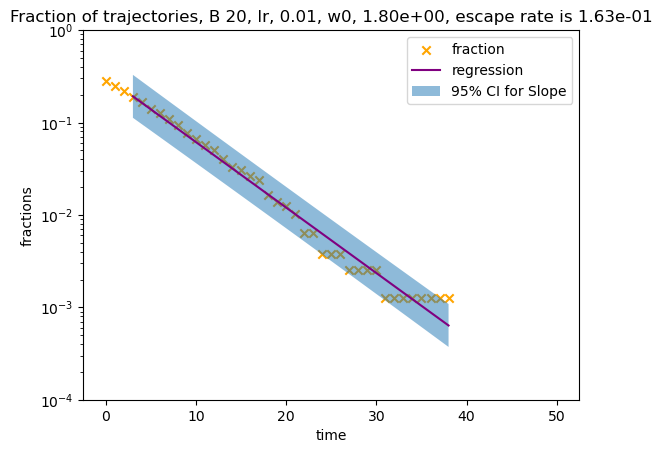

In [4]:
%matplotlib inline
trajectories = np.asarray(df['trajectory'].to_list())
clean_traj = trajectories[~np.isnan(trajectories).any(axis=1)]
fraction = regular_fraction(clean_traj, model)
escape_rate, error = compute_escape_rate(fraction, frac_max=frac_max, tmin=3,
                            batch_size=batch_size, lr=0.01, w0=w0)

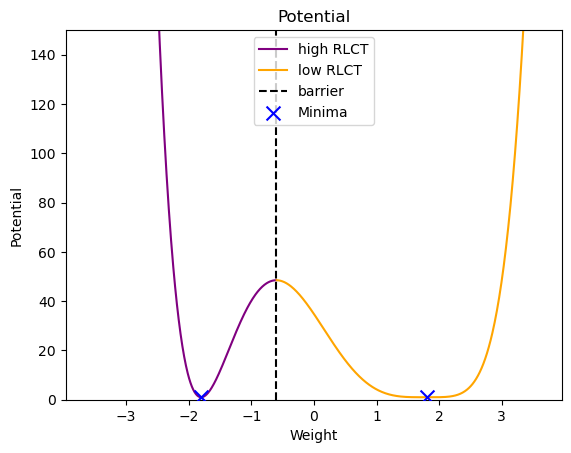

In [5]:
plot_potential(model, nsamp = 10**4, ymax = 150)

## Plot trajectories when escaping in 2D

In [23]:
# Initialise
nSGD = 1
wxm = 0.5
wym = 3
nsamples = 10**4
shuffle = True
batch_size= 20
lr = 0.1
seed_init = 1
seed_data = 1
d = 1
model = PolyModel2D(d=d, seed=seed_init, wxm=wxm, wym=wym)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories2d(model)

In [24]:
df

,w1_init,w2_init,trajectory1,trajectory2,loss
0,0.017698,1.203021,"[-0.082977995297426, -0.07596743255276062, -0....","[1.3219469606529488, 1.3202207677390563, 1.320...","[1.0560955216630827, 0.593158524924928, 0.7207..."


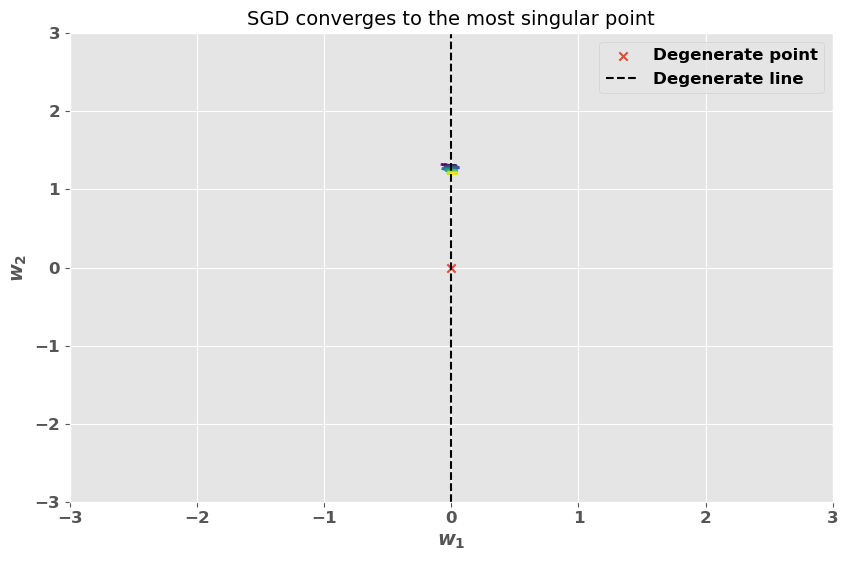

In [26]:
%matplotlib inline
from colorline import colorline
fig, ax = plt.subplots()
x, y = [df["trajectory1"][0], df["trajectory2"][0]]
z = np.linspace(0, 1, len(x))
colorline(ax, x, y, z, cmap=plt.get_cmap('viridis'), linewidth=2)
plt.xlabel(r"$w_1$")
plt.ylabel(r"$w_2$")
plt.xlim((-wym, wym))
plt.ylim((-wym, wym))
plt.grid(True)
plt.title("SGD converges to the most singular point")
plt.scatter(0,0,marker='x', label="Degenerate point")
plt.axvline(x=0, linestyle='--',label = "Degenerate line", color='k')
plt.legend()
plt.show()

# Compute Bayesian posterior

In [8]:
nSGD = 10**3
nsamples = 10**3
shuffle = True
batch_size= 20
lr = 0.01
w0 = 1.8
seed_init = 1
seed_data = 1
nw0 = 2
wmax = nw0 * w0
model = PolyModel(w0=w0, seed=seed_init, wmax=wmax, wmin=-wmax)

num_samples = 1000
x = torch.randn(num_samples, 1)  # Input data
y = torch.randn(num_samples, 1)  # Target data
step_size = 0.1

posterior_samples = metropolis_hastings(model, x, y, num_samples, step_size)

In [13]:
posterior_samples[0]

tensor([[0.4827]], grad_fn=<CloneBackward0>)

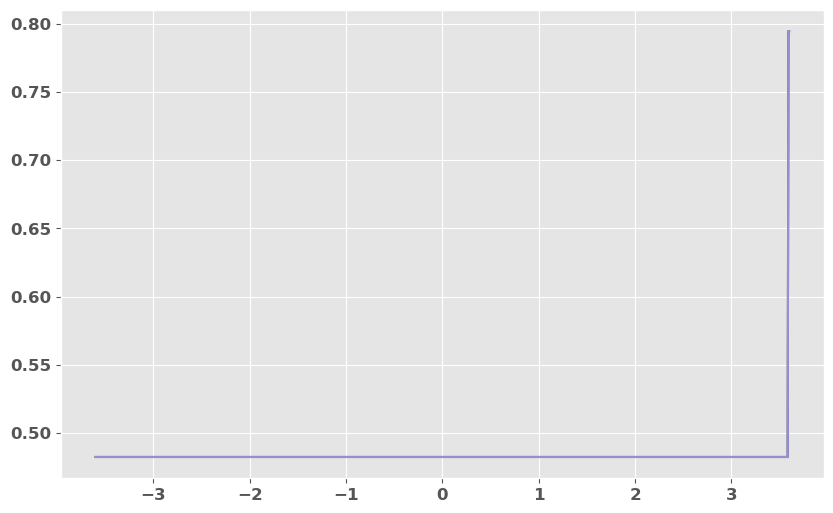

In [16]:
%matplotlib inline
posterior = [posterior_samples[i].item() for i in range(num_samples)]
wrange = np.linspace(-wmax, wmax, num_samples)
plt.plot(wrange, posterior)
plt.show()

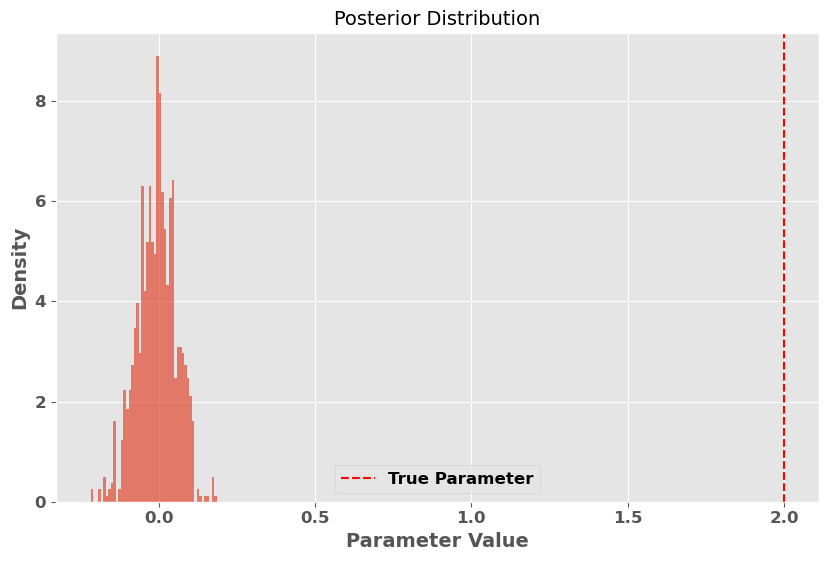

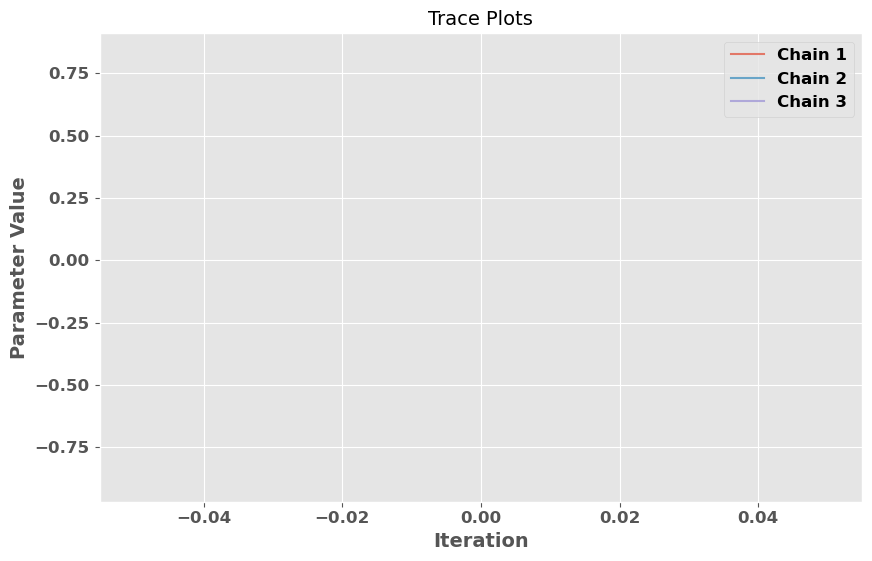

RuntimeError: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.

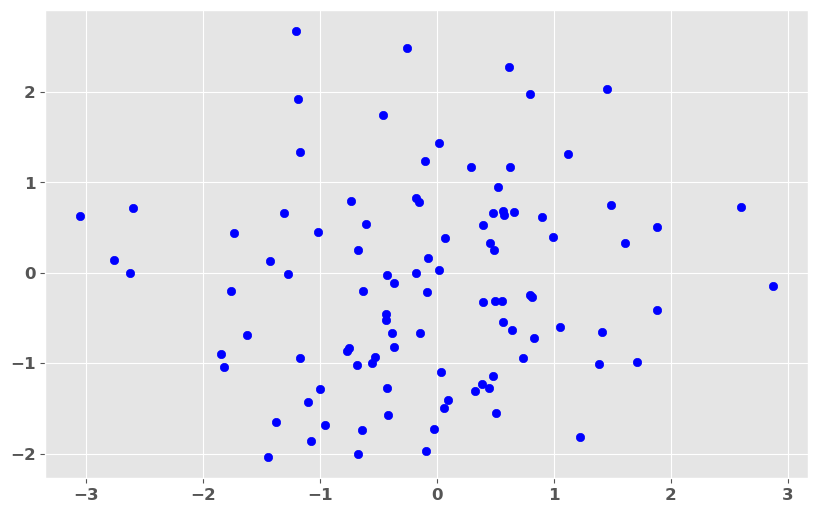

In [19]:
import torch
import matplotlib.pyplot as plt

# Synthetic Data Test
def synthetic_data_test(model, true_params, num_samples, step_size):
    # Generate synthetic data
    x = torch.linspace(-5, 5, 100).unsqueeze(1)
    y = model(x) + torch.randn_like(x) * 0.1

    # Run the MH algorithm
    posterior_samples = metropolis_hastings(model, x, y, num_samples, step_size)

    # Plot the posterior distribution
    posterior = [posterior_samples[i].item() for i in range(num_samples)]
    plt.figure()
    plt.hist(posterior, bins=50, density=True, alpha=0.7)
    plt.axvline(true_params, color='red', linestyle='--', label='True Parameter')
    plt.legend()
    plt.xlabel('Parameter Value')
    plt.ylabel('Density')
    plt.title('Posterior Distribution')
    plt.show()

# Convergence Test
def convergence_test(model, x, y, num_samples, step_size, num_chains):
    posterior_samples = []
    for i in range(num_chains):
        # Initialize with different starting points
        model.weight.data = torch.randn_like(model.weight)
        samples = metropolis_hastings(model, x, y, num_samples, step_size)
        posterior_samples.append(samples[i].item())

    # Plot the trace plots
    plt.figure()
    for i in range(num_chains):
        plt.plot(posterior_samples[i], alpha=0.7, label=f'Chain {i+1}')
    plt.legend()
    plt.xlabel('Iteration')
    plt.ylabel('Parameter Value')
    plt.title('Trace Plots')
    plt.show()

# Posterior Predictive Check
def posterior_predictive_check(model, x, y, posterior_samples):
    # Generate new data from the posterior predictive distribution
    num_samples = len(posterior_samples)
    y_pred = torch.zeros((num_samples, len(x)))
    for i, sample in enumerate(posterior_samples):
        model.weight.data = sample
        y_pred[i] = model(x).squeeze()

    # Plot the observed data and the posterior predictive distribution
    plt.figure()
    plt.scatter(x, y, color='blue', label='Observed Data')
    plt.plot(x, y_pred.mean(dim=0), color='red', label='Posterior Predictive Mean')
    plt.fill_between(x.squeeze(), y_pred.quantile(0.025, dim=0), y_pred.quantile(0.975, dim=0),
                     color='red', alpha=0.2, label='95% Credible Interval')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Posterior Predictive Check')
    plt.show()

# Example usage
true_params = torch.tensor([2.0])  # True parameter value for synthetic data
model = PolyModel(w_init=torch.tensor([0.0]))
num_samples = 1000
step_size = 0.1
num_chains = 3

# Synthetic Data Test
synthetic_data_test(model, true_params, num_samples, step_size)

# Convergence Test
x = torch.randn(100, 1)  # Input data
y = torch.randn(100, 1)  # Target data
convergence_test(model, x, y, num_samples, step_size, num_chains)

# Posterior Predictive Check
posterior_samples = metropolis_hastings(model, x, y, num_samples, step_size)
posterior_predictive_check(model, x, y, posterior_samples)